# Elasticnet batch 


什麼時候用它？
當溫度感測點高度共線（很常見）且你希望自動選擇/壓縮特徵、降低過度擬合。ElasticNet 介於 Lasso 與 Ridge 之間，很適合這類多溫度感測器的資料。

做法概觀

讀取多個訓練 CSV 並合併；2) 只用數值欄（去掉目標）做特徵；3) 標準化；4) 用 ElasticNetCV（交叉驗證調 α 與 l1_ratio）；5) 以「每檔案第 101 筆起」計算競賽版 RMSE。

注意：下方評估是「單一全域模型」在每個檔案上第 101 筆之後做預測；不會偷用第 100 筆之後的正解（避免洩漏）。

可再加強的特徵（先把 baseline 跑起來再疊）：

時間衍生：Time 的多項式/分段（因三階段轉速進給），或加「階段 one-hot」。

溫度動態：移動平均/移動差分（例如各溫度 5/15 分鐘均值與斜率）。

相對溫度：各點相對於環境基準（如 PT01 或全體平均）的差。

以上都能用 pd.DataFrame.rolling() / .diff() 做出來，只要避免用到未來資訊即可（使用當下與過去）。

In [11]:
# ==== ElasticNet 版 ====
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.multioutput import MultiOutputRegressor

# ---- 實際資料夾路徑 (已代入絕對路徑) ----
BASE_DIR = "/Users/benjamin/1132/11325/AI_Race/2025_dataset_0806 3"
TRAIN_DIR = f"{BASE_DIR}/train"          # 43 個訓練檔所在
TEST_DIR  = f"{BASE_DIR}/train"          # 暫時先指向同資料夾做流程驗證；若有正式 test 資料夾再改
OUT_DIR_ELASTIC = "/Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet"  # ElasticNet 預測輸出

TARGETS = ["Disp. X", "Disp. Z"]

# ========== 輔助：檢查資料夾 ==========
def _assert_folder_has_csv(folder, role):
    files = sorted(glob(str(Path(folder) / "*.csv")))
    if len(files) == 0:
        raise ValueError(f"{role} 資料夾 '{folder}' 下找不到任何 CSV，請確認路徑是否正確 (絕對路徑 & 無打錯)。")
    return files

# ========== 載入 ==========
def load_many_csvs(folder):
    files = _assert_folder_has_csv(folder, "訓練")
    dfs = []
    for f in files:
        df = pd.read_csv(f, low_memory=False)
        df["__file__"] = Path(f).name  # 評估與輸出用
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True), files

# ========== 組特徵/目標 ==========
def build_Xy(df):
    # 取出非目標欄且非輔助欄位
    raw_feat_cols = [c for c in df.columns if c not in TARGETS + ["__file__"]]
    # 僅保留可轉成數值的欄位，避免 "could not convert string to float" 類錯誤
    numeric_cols = []
    for c in raw_feat_cols:
        ser_num = pd.to_numeric(df[c], errors="coerce")
        valid_ratio = ser_num.notna().mean()
        if valid_ratio > 0.95:  # 門檻可調
            numeric_cols.append(c)
    if len(numeric_cols) == 0:
        raise ValueError("沒有可用的數值特徵欄位；請檢查資料是否載入正確或調整特徵挑選邏輯。")
    X = df[numeric_cols].to_numpy(dtype=float)
    y = None
    if all(t in df.columns for t in TARGETS):
        y = df[TARGETS].to_numpy(dtype=float)
    return X, y, numeric_cols

# ========== 建模 ==========
def fit_elasticnet(X, y, random_state=42):
    if y is None:
        raise ValueError("訓練資料缺少目標欄位，請確認 TRAIN_DIR 內 CSV 是否包含 Disp. X / Disp. Z。")
    if X.shape[0] == 0:
        raise ValueError("沒有任何訓練樣本：檢查資料夾或特徵過濾條件。")
    en = Pipeline([
        ("scaler", StandardScaler()),
        ("reg", MultiOutputRegressor(ElasticNetCV(
            l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
            alphas=np.logspace(-4, 2, 30),
            max_iter=5000,
            cv=5,
            n_jobs=None,
            random_state=random_state
        )))
    ])
    en.fit(X, y)
    return en

# 競賽 RMSE：對每個檔案，只計第 101 列以後
def competition_rmse(df_all, model):
    rmse_sum = 0.0
    n_rows_eval = 0
    for fname, g in df_all.groupby("__file__"):
        if not all(t in g.columns for t in TARGETS):
            continue  # 測試集沒有正解就略過
        if len(g) <= 100:
            continue
        feat_cols = [c for c in g.columns if c not in TARGETS + ["__file__"]]
        Xg_df = g[feat_cols].apply(pd.to_numeric, errors="coerce")
        Xg_df = Xg_df.dropna(axis=1, how="any")
        Xg = Xg_df.to_numpy(dtype=float)
        yg = g[TARGETS].to_numpy(dtype=float)
        if Xg.shape[0] <= 100:
            continue
        yhat = model.predict(Xg[100:])          # 只評 101+
        diff2 = (yhat - yg[100:]) ** 2
        rmse_sum += diff2.sum()
        n_rows_eval += len(g) - 100
    if n_rows_eval == 0:
        raise ValueError("評估時沒有可用的列 (可能所有檔案都不足 101 列或缺目標)。")
    return np.sqrt(rmse_sum / (2 * n_rows_eval))  # 2 來自 X/Z

# ---- 主流程（訓練 + 評估（在訓練資料上做類測試切法））----
train_df, train_files = load_many_csvs(TRAIN_DIR)
X_train, y_train, feat_cols = build_Xy(train_df)
print(f"Loaded {len(train_files)} train files, shape={train_df.shape}, features_kept={len(feat_cols)}")

en_model = fit_elasticnet(X_train, y_train)

rmse_train_like = competition_rmse(train_df, en_model)
print(f"[ElasticNet] pseudo-eval RMSE on TRAIN (101+): {rmse_train_like:.6f}")

# ---- 產生 13 個提交檔 ----
def write_submission_files(model, test_folder, out_folder, model_name="Unknown"):
    Path(out_folder).mkdir(parents=True, exist_ok=True)
    test_files = sorted(glob(str(Path(test_folder) / "*.csv")))
    if len(test_files) == 0:
        raise ValueError(f"測試資料夾 '{test_folder}' 無 CSV。")
    for f in test_files:
        df = pd.read_csv(f, low_memory=False)
        feat_cols = [c for c in df.columns if c not in TARGETS]  # 測試集頭 100 有真值欄位
        Xdf = df[feat_cols].apply(pd.to_numeric, errors="coerce")
        Xdf = Xdf.fillna(method="ffill").fillna(method="bfill")  # 簡單填補 (可改進)
        yhat = model.predict(Xdf.to_numpy(dtype=float))
        out = df.copy()
        if all(t in out.columns for t in TARGETS):
            out.loc[100:, "Disp. X"] = yhat[100:, 0]
            out.loc[100:, "Disp. Z"] = yhat[100:, 1]
        else:
            out["Disp. X"] = df.get("Disp. X", np.nan)
            out["Disp. Z"] = df.get("Disp. Z", np.nan)
            out.loc[100:, "Disp. X"] = yhat[100:, 0]
            out.loc[100:, "Disp. Z"] = yhat[100:, 1]
        out_path = Path(out_folder) / Path(f).name
        out.to_csv(out_path, index=False)
        print(f"[{model_name}] wrote:", out_path)

# (如需輸出，請在下個 debug/submission cell 呼叫 write_submission_files)

Loaded 43 train files, shape=(29795, 28), features_kept=25


/Users/benjamin/1132/11325/AI_Race/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.838e+03, tolerance: 9.465e+02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/benjamin/1132/11325/AI_Race/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.165e+05, tolerance: 9.465e+02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/benjamin/1132/11325/AI_Race/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sc

[ElasticNet] pseudo-eval RMSE on TRAIN (101+): 8.088681


/Users/benjamin/1132/11325/AI_Race/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.234e+05, tolerance: 5.470e+02
  model = cd_fast.enet_coordinate_descent(


In [12]:
# === Debug / 快速檢視 & 產出提交檔 ===
from pathlib import Path
import pandas as pd

print("TRAIN_DIR:", TRAIN_DIR)
print("TEST_DIR :", TEST_DIR)
print("OUT_DIR_ELASTIC  :", OUT_DIR_ELASTIC)

# 1) 列出前 5 個訓練檔案名稱
train_files_list = sorted(Path(TRAIN_DIR).glob('*.csv'))
print(f"訓練檔數: {len(train_files_list)} (列出前5)")
for p in train_files_list[:5]:
    print("  -", p.name)

# 2) 讀第一個檔案看欄位與前幾列
if train_files_list:
    sample_df = pd.read_csv(train_files_list[0], nrows=8)
    print("樣本檔欄位:", list(sample_df.columns))
    display(sample_df.head())

# 3) 顯示特徵保留數
print(f"保留特徵數: {len(feat_cols)} → 前10: {feat_cols[:10]}")

# 4) 產出 ElasticNet 提交檔
print("開始寫出 ElasticNet 預測檔 ...")
write_submission_files(en_model, TEST_DIR, OUT_DIR_ELASTIC, "ElasticNet")
print("完成。可到 preds_out_elasticnet 查看。")

# 5) 檢查輸出資料夾內前幾個檔案
out_files = sorted(Path(OUT_DIR_ELASTIC).glob('*.csv'))
print(f"ElasticNet 輸出檔數: {len(out_files)} (列出前5)")
for p in out_files[:5]:
    print("  ->", p.name)

TRAIN_DIR: /Users/benjamin/1132/11325/AI_Race/2025_dataset_0806 3/train
TEST_DIR : /Users/benjamin/1132/11325/AI_Race/2025_dataset_0806 3/train
OUT_DIR_ELASTIC  : /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet
訓練檔數: 43 (列出前5)
  - _20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-from0-25C).csv
  - _20200616_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-from0-25C).csv
  - _20200617_GV1-1203_1k+2krpm_XZ-5m-min_5H(wAC-from0-25C).csv
  - _20200618_GV1-1203_2k+1krpm_XZ-5m-min_5H(wAC-from0-25C).csv
  - _20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-from0-20C).csv
樣本檔欄位: ['Time', 'PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08', 'Spindle Motor', 'X Motor', 'Z Motor', 'Disp. X', 'Disp. Z']


,Time,PT01,PT02,PT03,PT04,PT05,PT06,PT07,PT08,PT09,...,TC04,TC05,TC06,TC07,TC08,Spindle Motor,X Motor,Z Motor,Disp. X,Disp. Z
0,1.017,21.5,21.7,21.8,21.1,21.2,20.9,20.9,21.6,21.1,...,19.1,19.4,19.6,21.6,22.3,19.0,19.0,20.0,0.000000,0.000000
1,1.185,21.5,21.8,21.8,21.1,21.2,20.9,20.9,21.6,21.2,...,19.4,19.5,19.7,21.7,22.4,19.0,19.0,20.0,0.000000,0.086104
2,1.354,21.5,21.8,21.8,21.1,21.2,20.9,20.9,21.6,21.2,...,19.2,19.5,19.8,21.7,22.4,19.0,20.0,20.0,-1.188165,0.086104
3,1.523,21.5,21.7,21.8,21.1,21.2,21.0,20.9,21.7,21.2,...,19.2,19.5,19.7,21.7,22.5,19.0,19.0,20.0,-2.178043,0.171982
4,1.691,21.5,21.8,21.8,21.1,21.2,21.0,20.9,21.7,21.3,...,19.3,19.6,19.8,21.8,22.5,19.0,19.0,20.0,-2.178043,0.171982


保留特徵數: 25 → 前10: ['Time', 'PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09']
開始寫出 ElasticNet 預測檔 ...
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-from0-25C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200616_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-from0-25C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200617_GV1-1203_1k+2krpm_XZ-5m-min_5H(wAC-from0-25C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200618_GV1-1203_2k+1krpm_XZ-5m-min_5H(wAC-from0-25C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-from0-20C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200702_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-from0-20C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_e

/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1592365879.py:120: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Xdf = Xdf.fillna(method="ffill").fillna(method="bfill")  # 簡單填補 (可改進)
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1592365879.py:120: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Xdf = Xdf.fillna(method="ffill").fillna(method="bfill")  # 簡單填補 (可改進)
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1592365879.py:120: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Xdf = Xdf.fillna(method="ffill").fillna(method="bfill")  # 簡單填補 (可改進)
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1592365879.py:120: FutureWarning: DataFrame.fillna with 'me

[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200810_GV1-1203_1-8k_XZ-5m-min_2-5H+Stop1H+1-2k_XZ-5m-min_2-5H(wAC-from0-30C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200813_GV1-1203_2000rpm_XZ-5m-min_6H(wAC-from0-30Cto20C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200814_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-from0-30Cto20C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200817_GV1-1203_2000rpm_XZ-5m-min_6H(wAC-from0-20Cto30C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200818_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-from0-20Cto30C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200820_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-from0-18C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200821_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-from0-22C).csv
[ElasticN

/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1592365879.py:120: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Xdf = Xdf.fillna(method="ffill").fillna(method="bfill")  # 簡單填補 (可改進)
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1592365879.py:120: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Xdf = Xdf.fillna(method="ffill").fillna(method="bfill")  # 簡單填補 (可改進)
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1592365879.py:120: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Xdf = Xdf.fillna(method="ffill").fillna(method="bfill")  # 簡單填補 (可改進)
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1592365879.py:120: FutureWarning: DataFrame.fillna with 'me

[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200916_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-from0-30to20C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200918_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-from0-15to20C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200923_GV1-1203_2krpm_XZ-5m-min_2-5H+Stop1H+2krpm_XZ-5m-min_2-5H(wAC-from0-30C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200924_GV1-1203_1krpm_XZ-5m-min_2-5H+Stop1H+1krpm_XZ-5m-min_2-5H(wAC-from0-30C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200928_GV1-1203_1krpm_XZ-5m-min_2-5H+Stop1H+2krpm_XZ-5m-min_2-5H(wAC-from0-20C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet/_20200929_GV1-1203_2krpm_XZ-5m-min_2-5H+Stop1H+1krpm_XZ-5m-min_2-5H(wAC-from0-20C).csv
[ElasticNet] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_elast

/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1592365879.py:120: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Xdf = Xdf.fillna(method="ffill").fillna(method="bfill")  # 簡單填補 (可改進)
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1592365879.py:120: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Xdf = Xdf.fillna(method="ffill").fillna(method="bfill")  # 簡單填補 (可改進)
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1592365879.py:120: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Xdf = Xdf.fillna(method="ffill").fillna(method="bfill")  # 簡單填補 (可改進)
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1592365879.py:120: FutureWarning: DataFrame.fillna with 'me

# Bayesian Linear Regression


什麼時候用它？
當你要「線性關係 + 不確定性」估計，且特徵很多又易共線時，BayesianRidge 透過先驗/後驗得到更穩的權重估計，常比一般最小平方法更抗雜訊。

下方流程與 ElasticNet 幾乎相同，只是把估計器換成 BayesianRidge。

In [13]:
# === BayesianRidge 版 ===
import os
import glob
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ======== 路徑設定 ========
TRAIN_DIR_BAYES = "/Users/benjamin/1132/11325/AI_Race/2025_dataset_0806 3/train"
TEST_DIR_BAYES = "/Users/benjamin/1132/11325/AI_Race/2025_dataset_0806 3/train"
OUT_DIR_BAYES = "/Users/benjamin/1132/11325/AI_Race/preds_out_bayesian"
Path(OUT_DIR_BAYES).mkdir(parents=True, exist_ok=True)

# ======== 資料欄位設定（依實際資料欄位） ========
FEATURES_BAYES = (
    ["Time"] +
    [f"PT{i:02d}" for i in range(1, 14)] +
    [f"TC{i:02d}" for i in range(1, 9)] +
    ["Spindle Motor", "X Motor", "Z Motor"]
)
TARGET_X = "Disp. X"
TARGET_Z = "Disp. Z"

def load_train_df_bayes():
    files = glob.glob(os.path.join(TRAIN_DIR_BAYES, "*.csv"))
    dfs = []
    for f in files:
        df = pd.read_csv(f, low_memory=False)
        dfs.append(df)
    train_df = pd.concat(dfs, ignore_index=True)
    return train_df

def make_bayes_pipeline():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", BayesianRidge(
            # alpha_1, alpha_2, lambda_1, lambda_2 可依需求微調先驗；先用預設即可
        ))
    ])

def fit_bayes_models(train_df):
    # 使用與 ElasticNet 相同的特徵選擇邏輯
    available_features = [f for f in FEATURES_BAYES if f in train_df.columns]
    print(f"BayesianRidge 可用特徵: {len(available_features)}/{len(FEATURES_BAYES)}")
    
    X = train_df[available_features].apply(pd.to_numeric, errors="coerce")
    X = X.fillna(method="ffill").fillna(method="bfill")  # 簡單填補
    yx = train_df[TARGET_X]
    yz = train_df[TARGET_Z]

    pipe_x = make_bayes_pipeline()
    pipe_z = make_bayes_pipeline()

    pipe_x.fit(X, yx)
    pipe_z.fit(X, yz)
    return pipe_x, pipe_z, available_features

def predict_and_save_bayes(pipe_x, pipe_z, features_used):
    test_files = glob.glob(os.path.join(TEST_DIR_BAYES, "*.csv"))
    for f in test_files:
        df = pd.read_csv(f, low_memory=False)
        available_features = [feat for feat in features_used if feat in df.columns]
        X_test = df[available_features].apply(pd.to_numeric, errors="coerce")
        X_test = X_test.fillna(method="ffill").fillna(method="bfill")
        
        if len(df) > 100:
            pred_x = pipe_x.predict(X_test.iloc[100:])
            pred_z = pipe_z.predict(X_test.iloc[100:])
            df.loc[100:, TARGET_X] = pred_x
            df.loc[100:, TARGET_Z] = pred_z
        
        out = os.path.join(OUT_DIR_BAYES, os.path.basename(f))
        df.to_csv(out, index=False)
        print(f"[BayesianRidge] wrote: {out}")

def main_bayes():
    print("=== BayesianRidge 訓練開始 ===")
    train_df = load_train_df_bayes()
    print(f"載入訓練資料: {train_df.shape}")
    
    pipe_x, pipe_z, features_used = fit_bayes_models(train_df)

    # 查看後驗係數均值與標準差（不確定性）
    brx = pipe_x.named_steps["model"]
    brz = pipe_z.named_steps["model"]
    print(f"[BayesianRidge] X coef shape: {brx.coef_.shape}, alpha_={brx.alpha_:.4f}, lambda_={brz.lambda_:.4f}")
    print(f"[BayesianRidge] Z coef shape: {brz.coef_.shape}, alpha_={brz.alpha_:.4f}, lambda_={brz.lambda_:.4f}")

    predict_and_save_bayes(pipe_x, pipe_z, features_used)
    print("BayesianRidge 預測檔案已儲存到 preds_out_bayesian/")
    
    return pipe_x, pipe_z

# 執行 BayesianRidge 訓練
pipe_x, pipe_z = main_bayes()

=== BayesianRidge 訓練開始 ===
載入訓練資料: (29795, 27)
BayesianRidge 可用特徵: 25/25
[BayesianRidge] X coef shape: (25,), alpha_=0.0108, lambda_=0.0016
[BayesianRidge] Z coef shape: (25,), alpha_=0.0388, lambda_=0.0016
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200907_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-from0-15to35C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200617_GV1-1203_1k+2krpm_XZ-5m-min_5H(wAC-from0-25C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200914_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-from0-20to30C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200709_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-from0-20Cto25C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200703_GV1-1203_1k+2krpm_XZ-5m-min_5H(wAC-from0-20C).csv


/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1247884525.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill").fillna(method="bfill")  # 簡單填補
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1247884525.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.fillna(method="ffill").fillna(method="bfill")
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1247884525.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.fillna(method="ffill").fillna(method="bfill")
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1247884525.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will r

[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200828_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-from0-35C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200729_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-from0-30C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200916_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-from0-30to20C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200813_GV1-1203_2000rpm_XZ-5m-min_6H(wAC-from0-30Cto20C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200616_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-from0-25C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200713_GV1-1203_2k+1krpm_XZ-5m-min_6H(wAC-from0-20Cto25C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200827_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-from0-15C).csv
[BayesianRidge] wrote: /Users/ben

/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1247884525.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.fillna(method="ffill").fillna(method="bfill")
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1247884525.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.fillna(method="ffill").fillna(method="bfill")
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1247884525.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.fillna(method="ffill").fillna(method="bfill")
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1247884525.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will

[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-from0-20C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200918_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-from0-15to20C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20201005_GV1-1203_1krpm_XZ-5m-min_2-5H+Stop1H+1krpm_XZ-5m-min_2-5H(wAC-from0-20C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200904_GV1-1203_1k+2krpm_XZ-5m-min_5H(wAC-from0-15C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200723_GV1-1203_ConditionCombined(wAC-from0-25Cto20C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200708_GV1-1203_2000rpm_XZ-5m-min_6H(wAC-from0-20Cto25C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200924_GV1-1203_1krpm_XZ-5m-min_2-5H+Stop1H+1krpm_XZ-5m-min_2-5H

/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1247884525.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.fillna(method="ffill").fillna(method="bfill")
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1247884525.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.fillna(method="ffill").fillna(method="bfill")
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1247884525.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.fillna(method="ffill").fillna(method="bfill")
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1247884525.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will

[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200702_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-from0-20C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200814_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-from0-30Cto20C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200727_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-from0-30C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200710_GV1-1203_1k+2krpm_XZ-5m-min_6H(wAC-from0-20Cto25C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20200810_GV1-1203_1-8k_XZ-5m-min_2-5H+Stop1H+1-2k_XZ-5m-min_2-5H(wAC-from0-30C).csv
[BayesianRidge] wrote: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian/_20201006_GV1-1203_2krpm_XZ-5m-min_2-5H+Stop1H+2krpm_XZ-5m-min_2-5H(wAC-from0-20C).csv
BayesianRidge 預測檔案已儲存到 preds_out_bayesian/


## 為什麼 ElasticNet 訓練這麼快？
線性模型 (ElasticNetCV) 在這個資料集上會很快是正常的：
- 問題是凸優化，使用座標下降 (coordinate descent) 收斂快。
- 特徵欄位數（篩掉非數值後）遠少於深度模型動輒上千萬參數。
- 雖然 ElasticNetCV 做 5-fold * 多個 alpha * 多個 l1_ratio (≈ 5 * 30 * 5 = 750 次擬合 / 目標)，資料量仍不大所以幾秒就結束。
- MultiOutputRegressor 只是對兩個目標各跑一次，仍屬輕量。

如果：
- 你看到幾乎瞬間完成，有可能是資料列數沒想像多（可檢查 train_df.shape）。
- 要花「幾小時」通常出現在：極大量樣本、極多特徵、高維稀疏矩陣、或使用深度學習/大型樹模型。

下面提供：
1. 重新計時訓練耗時。
2. 每個檔案 (101+ 行) 的 RMSE 分解表。
3. 係數 (前後 10 個最大絕對值特徵)。
4. RMSE 分佈簡單統計。
5. 若要更慢/更強：可改用 Gradient Boosting / LightGBM / XGBoost / 神經網路。


In [6]:
# === 模型診斷：耗時 / 每檔 RMSE / 重要特徵 ===
import time, math
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import display

# 重新計時訓練 (僅示意，若已在記憶體就快速重跑)
_start = time.time()
X_train2, y_train2, feat_cols2 = X_train, y_train, feat_cols  # 已有資料
model_tmp = fit_elasticnet(X_train2, y_train2)
_train_time = time.time() - _start
print(f"重新訓練耗時: {_train_time:.2f} 秒 (含 CV)")

# 每檔案 RMSE (101+)
rows = []
for fname, g in train_df.groupby("__file__"):
    if not all(t in g.columns for t in TARGETS) or len(g) <= 100:
        continue
    feat_cols_file = [c for c in g.columns if c not in TARGETS + ["__file__"]]
    Xg = g[feat_cols_file].apply(pd.to_numeric, errors="coerce").dropna(axis=1, how="any").to_numpy(dtype=float)
    yg = g[TARGETS].to_numpy(dtype=float)
    if Xg.shape[0] <= 100:
        continue
    yhat = en_model.predict(Xg[100:])
    diff2 = (yhat - yg[100:]) ** 2
    rmse_file = math.sqrt(diff2.sum() / (2 * (len(g) - 100)))
    rows.append({"file": fname, "rmse_101p": rmse_file, "rows_total": len(g)})

rmse_df = pd.DataFrame(rows).sort_values("rmse_101p")
print("每檔案 RMSE (前 10 佳):")
display(rmse_df.head(10))
print("整體描述統計:")
print(rmse_df["rmse_101p"].describe())

# 重要特徵：取兩個子模型的係數 (ElasticNetCV 每目標一組)
reg_list = en_model.named_steps['reg'].estimators_
coef_X = reg_list[0].coef_
coef_Z = reg_list[1].coef_
coef_df = pd.DataFrame({
    'feature': feat_cols,
    'coef_X': coef_X,
    'coef_Z': coef_Z,
    'abs_X': np.abs(coef_X),
    'abs_Z': np.abs(coef_Z),
    'abs_mean': (np.abs(coef_X)+np.abs(coef_Z))/2,
})
# 取前後各 10 個 (按 abs_mean)
important = pd.concat([
    coef_df.sort_values('abs_mean', ascending=False).head(10),
    coef_df.sort_values('abs_mean', ascending=True).head(10)
])
print("特徵重要性 (前 10 大與最小 10):")
display(important)

# 若要視覺化可再加：
# import seaborn as sns, matplotlib.pyplot as plt
# sns.barplot(data=coef_df.sort_values('abs_mean', ascending=False).head(20), x='abs_mean', y='feature')
# plt.show()


/Users/benjamin/1132/11325/AI_Race/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.838e+03, tolerance: 9.465e+02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/benjamin/1132/11325/AI_Race/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.165e+05, tolerance: 9.465e+02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/benjamin/1132/11325/AI_Race/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sc

重新訓練耗時: 6.81 秒 (含 CV)
每檔案 RMSE (前 10 佳):


/Users/benjamin/1132/11325/AI_Race/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.234e+05, tolerance: 5.470e+02
  model = cd_fast.enet_coordinate_descent(


,file,rmse_101p,rows_total
38,_20200928_GV1-1203_1krpm_XZ-5m-min_2-5H+Stop1H...,3.060897,609
11,_20200713_GV1-1203_2k+1krpm_XZ-5m-min_6H(wAC-f...,3.191532,609
1,_20200616_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,3.995029,605
5,_20200702_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,3.996852,592
20,_20200814_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-fr...,4.150626,607
16,_20200805_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,4.171696,609
4,_20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,4.275910,605
18,_20200810_GV1-1203_1-8k_XZ-5m-min_2-5H+Stop1H+...,4.361266,609
14,_20200729_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,4.448326,541
8,_20200708_GV1-1203_2000rpm_XZ-5m-min_6H(wAC-fr...,4.478559,606


整體描述統計:
count    43.000000
mean      6.883250
std       4.627030
min       3.060897
25%       4.620216
50%       5.567530
75%       7.315902
max      29.645267
Name: rmse_101p, dtype: float64
特徵重要性 (前 10 大與最小 10):


,feature,coef_X,coef_Z,abs_X,abs_Z,abs_mean
5,PT05,110.590142,59.703471,110.590142,59.703471,85.146806
19,TC06,-111.192606,-23.956890,111.192606,23.956890,67.574748
3,PT03,74.470002,-16.446961,74.470002,16.446961,45.458482
2,PT02,-53.066746,-25.015036,53.066746,25.015036,39.040891
16,TC03,60.969054,9.079308,60.969054,9.079308,35.024181
13,PT13,-45.788002,-14.567801,45.788002,14.567801,30.177901
14,TC01,20.790290,27.928610,20.790290,27.928610,24.359450
7,PT07,13.659037,34.270764,13.659037,34.270764,23.964901
18,TC05,14.400631,-32.133363,14.400631,32.133363,23.266997
4,PT04,44.850326,-0.574828,44.850326,0.574828,22.712577


# Bayesian Ridge 與 ElasticNet RMSE 比較



下面 Cell：
1. 將 BayesianRidge 兩個子模型 (X/Z) 與 ElasticNet 模型用統一的 101+ 評估規則計算 RMSE。
2. 回傳：
   - ElasticNet 整體 RMSE
   - BayesianRidge 整體 RMSE
   - 每個檔案分解 RMSE (兩模型各一份)
3. 額外輸出 MAE (101+) 以供參考。

評估公式：
RMSE = sqrt( Σ_i Σ_target ( (ŷ - y)^2 ) / ( N_rows_eval * 2 ) ) ，僅 i >= 101 (索引 100 之後)。
MAE 類似改成 |ŷ - y|。

注意：
- BayesianRidge 區塊的 TRAIN_DIR / FEATURES 若與 ElasticNet 不同，請確保一致或先行同步。
- 若 BayesianRidge 尚未執行 main()（pipe_x/pipe_z 未定義）會報錯，請先跑前面 bayesian cell。

In [14]:
# === 評估：ElasticNet vs BayesianRidge (101+ 行) RMSE / MAE ===
import math, os, glob
import pandas as pd
import numpy as np
from IPython.display import display

# 確保變數已定義（若前面 cell 未執行會報錯）
try:
    TRAIN_DIR, TARGETS, en_model
    print("✓ ElasticNet 相關變數已定義")
except NameError as e:
    print(f"❌ 請先執行前面的 ElasticNet 訓練 cell: {e}")
    raise

# ---- 共用評估函式 ----
def eval_two_targets_per_file(files, predict_fn):
    rows = []
    se_sum = 0.0
    ae_sum = 0.0
    n_rows_eval = 0
    for f in files:
        df = pd.read_csv(f, low_memory=False)
        if len(df) <= 100 or not all(t in df.columns for t in TARGETS):
            continue
        # 特徵欄位：沿用 ElasticNet 的方式（排除目標與輔助）
        feat_cols_file = [c for c in df.columns if c not in TARGETS]
        X_full = df[feat_cols_file].apply(pd.to_numeric, errors='coerce')
        X_full = X_full.dropna(axis=1, how='any')  # 保守：有 NaN 的整欄捨棄
        if X_full.shape[0] <= 100:
            continue
        y_true = df[TARGETS].to_numpy(dtype=float)
        y_pred = predict_fn(X_full.to_numpy(dtype=float))
        
        # ★ 競賽要求：只評估第 101 行之後 (index 100:)
        y_true_sub = y_true[100:]
        y_pred_sub = y_pred[100:]
        diff = y_pred_sub - y_true_sub
        se = (diff ** 2).sum()          # 兩目標合計平方和
        ae = np.abs(diff).sum()         # 兩目標合計絕對值和
        n_eff = len(y_true_sub)         # 列數
        
        # ★ 競賽 RMSE 公式：sqrt(SE / (2 * N))，2 來自 X/Z 兩個目標
        rmse_file = math.sqrt(se / (2 * n_eff))
        mae_file = ae / (2 * n_eff)
        rows.append({
            'file': os.path.basename(f),
            'rows_total': len(df),
            'rows_eval': n_eff,
            'rmse_101p': rmse_file,
            'mae_101p': mae_file,
        })
        se_sum += se
        ae_sum += ae
        n_rows_eval += n_eff
    
    # ★ 整體 RMSE：所有檔案合併計算
    overall_rmse = math.sqrt(se_sum / (2 * n_rows_eval)) if n_rows_eval else float('nan')
    overall_mae = ae_sum / (2 * n_rows_eval) if n_rows_eval else float('nan')
    detail_df = pd.DataFrame(rows).sort_values('rmse_101p')
    return overall_rmse, overall_mae, detail_df

# ---- ElasticNet 評估 ----
train_files_glob = sorted(glob.glob(os.path.join(TRAIN_DIR, '*.csv')))
print(f"找到訓練檔案數：{len(train_files_glob)}")

elastic_overall_rmse, elastic_overall_mae, elastic_detail = eval_two_targets_per_file(
    train_files_glob,
    predict_fn=lambda X: en_model.predict(X)
)
print(f"[ElasticNet] Overall RMSE(101+): {elastic_overall_rmse:.6f}  MAE(101+): {elastic_overall_mae:.6f}")

# ---- BayesianRidge 評估 ----
# 需要已先執行 bayesian 區塊，使 pipe_x, pipe_z 存在
try:
    pipe_x, pipe_z  # 檢查是否存在
    print("✓ BayesianRidge 模型已定義")
    
    def bayes_predict_wrapper(X_array: np.ndarray):
        # 注意：這裡假設 X_array 欄順序與 features_used 一致
        # 實際使用時可能需要重新對齊特徵欄位順序
        yx = pipe_x.predict(X_array)
        yz = pipe_z.predict(X_array)
        return np.column_stack([yx, yz])

    bayes_overall_rmse, bayes_overall_mae, bayes_detail = eval_two_targets_per_file(
        train_files_glob,
        predict_fn=bayes_predict_wrapper
    )
    print(f"[BayesianRidge] Overall RMSE(101+): {bayes_overall_rmse:.6f}  MAE(101+): {bayes_overall_mae:.6f}")
    
    # ---- 比較摘要 ----
    summary_df = pd.DataFrame([
        {'model': 'ElasticNet', 'RMSE_101p': elastic_overall_rmse, 'MAE_101p': elastic_overall_mae},
        {'model': 'BayesianRidge', 'RMSE_101p': bayes_overall_rmse, 'MAE_101p': bayes_overall_mae},
    ])
    print("\n=== Overall Comparison (101+) ===")
    display(summary_df)

    # 輸出路徑比較
    print(f"\n=== 📂 輸出路徑比較 ===")
    print(f"🔵 ElasticNet 預測檔: {OUT_DIR_ELASTIC}")
    print(f"🟣 BayesianRidge 預測檔: {OUT_DIR_BAYES}")
    
    # 檢查兩個資料夾的檔案數量
    elastic_files = len(list(Path(OUT_DIR_ELASTIC).glob('*.csv')))
    bayes_files = len(list(Path(OUT_DIR_BAYES).glob('*.csv')))
    print(f"🔵 ElasticNet 輸出檔數: {elastic_files}")
    print(f"🟣 BayesianRidge 輸出檔數: {bayes_files}")

    print("\n=== Top 8 Files (ElasticNet, lowest RMSE) ===")
    display(elastic_detail.head(8))
    print("\n=== Top 8 Files (BayesianRidge, lowest RMSE) ===")
    display(bayes_detail.head(8))

    # 同檔案 RMSE 差異比較
    comparison = elastic_detail[['file','rmse_101p']].merge(
        bayes_detail[['file','rmse_101p']], on='file', how='inner', suffixes=('_elastic','_bayes')
    )
    comparison['delta_bayes_minus_elastic'] = comparison['rmse_101p_bayes'] - comparison['rmse_101p_elastic']
    comparison['better_model'] = comparison['delta_bayes_minus_elastic'].apply(
        lambda x: 'ElasticNet' if x > 0 else 'BayesianRidge'
    )
    print("\n=== Per-file RMSE 差異 (Bayes - Elastic) (前 10) ===")
    display(comparison.sort_values('delta_bayes_minus_elastic').head(10))
    
    # 勝負統計
    elastic_wins = (comparison['delta_bayes_minus_elastic'] > 0).sum()
    bayes_wins = (comparison['delta_bayes_minus_elastic'] < 0).sum()
    ties = (comparison['delta_bayes_minus_elastic'] == 0).sum()
    
    print(f"\n=== 🏆 演算法勝負統計 ===")
    print(f"🔵 ElasticNet 較佳: {elastic_wins} 檔案")
    print(f"🟣 BayesianRidge 較佳: {bayes_wins} 檔案") 
    print(f"⚪ 平手: {ties} 檔案")
    
    if elastic_overall_rmse < bayes_overall_rmse:
        print(f"🏆 整體勝出: ElasticNet (RMSE差距: {bayes_overall_rmse - elastic_overall_rmse:.6f})")
    else:
        print(f"🏆 整體勝出: BayesianRidge (RMSE差距: {elastic_overall_rmse - bayes_overall_rmse:.6f})")
    
except NameError:
    print("❌ BayesianRidge 模型未定義，僅顯示 ElasticNet 結果")
    print("請先執行第 8 個 cell 中的 BayesianRidge 訓練代碼")
    print(f"[ElasticNet Only] Overall RMSE(101+): {elastic_overall_rmse:.6f}")
    print(f"🔵 ElasticNet 預測檔: {OUT_DIR_ELASTIC}")
    elastic_files = len(list(Path(OUT_DIR_ELASTIC).glob('*.csv')))
    print(f"🔵 ElasticNet 輸出檔數: {elastic_files}")
    print("\n=== Top 10 Files (ElasticNet, lowest RMSE) ===")
    display(elastic_detail.head(10))

✓ ElasticNet 相關變數已定義
找到訓練檔案數：43
[ElasticNet] Overall RMSE(101+): 8.088681  MAE(101+): 5.088545
✓ BayesianRidge 模型已定義
[BayesianRidge] Overall RMSE(101+): 8.057107  MAE(101+): 5.073574

=== Overall Comparison (101+) ===
[BayesianRidge] Overall RMSE(101+): 8.057107  MAE(101+): 5.073574

=== Overall Comparison (101+) ===


/Users/benjamin/1132/11325/AI_Race/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/benjamin/1132/11325/AI_Race/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/benjamin/1132/11325/AI_Race/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/benjamin/1132/11325/AI_Race/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/benjamin/1132/11325/AI_Race/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X d

,model,RMSE_101p,MAE_101p
0,ElasticNet,8.088681,5.088545
1,BayesianRidge,8.057107,5.073574



=== 📂 輸出路徑比較 ===
🔵 ElasticNet 預測檔: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet
🟣 BayesianRidge 預測檔: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian
🔵 ElasticNet 輸出檔數: 43
🟣 BayesianRidge 輸出檔數: 43

=== Top 8 Files (ElasticNet, lowest RMSE) ===


,file,rows_total,rows_eval,rmse_101p,mae_101p
38,_20200928_GV1-1203_1krpm_XZ-5m-min_2-5H+Stop1H...,609,509,3.060897,2.306699
11,_20200713_GV1-1203_2k+1krpm_XZ-5m-min_6H(wAC-f...,609,509,3.191532,2.496628
1,_20200616_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,605,505,3.995029,2.983093
5,_20200702_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,592,492,3.996852,3.377536
20,_20200814_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-fr...,607,507,4.150626,3.485930
16,_20200805_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,609,509,4.171696,3.173098
4,_20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,605,505,4.275910,3.393574
18,_20200810_GV1-1203_1-8k_XZ-5m-min_2-5H+Stop1H+...,609,509,4.361266,3.526984



=== Top 8 Files (BayesianRidge, lowest RMSE) ===


,file,rows_total,rows_eval,rmse_101p,mae_101p
38,_20200928_GV1-1203_1krpm_XZ-5m-min_2-5H+Stop1H...,609,509,3.326038,2.479693
11,_20200713_GV1-1203_2k+1krpm_XZ-5m-min_6H(wAC-f...,609,509,3.497063,2.773152
20,_20200814_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-fr...,607,507,3.950358,3.209568
1,_20200616_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,605,505,4.082929,3.030911
4,_20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,605,505,4.120797,3.240109
16,_20200805_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,609,509,4.241864,3.272573
5,_20200702_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,592,492,4.245496,3.554157
10,_20200710_GV1-1203_1k+2krpm_XZ-5m-min_6H(wAC-f...,608,508,4.549584,3.394553



=== Per-file RMSE 差異 (Bayes - Elastic) (前 10) ===


,file,rmse_101p_elastic,rmse_101p_bayes,delta_bayes_minus_elastic,better_model
40,_20200907_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-fr...,12.576325,12.085402,-0.490923,BayesianRidge
39,_20200914_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,10.921588,10.533318,-0.388269,BayesianRidge
37,_20201016_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-fr...,8.967945,8.645206,-0.322739,BayesianRidge
38,_20200924_GV1-1203_1krpm_XZ-5m-min_2-5H+Stop1H...,9.762651,9.506017,-0.256634,BayesianRidge
22,_20200918_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-fr...,5.764287,5.523493,-0.240794,BayesianRidge
24,_20200617_GV1-1203_1k+2krpm_XZ-5m-min_5H(wAC-f...,5.968023,5.734206,-0.233816,BayesianRidge
12,_20200710_GV1-1203_1k+2krpm_XZ-5m-min_6H(wAC-f...,4.776606,4.549584,-0.227022,BayesianRidge
26,_20200817_GV1-1203_2000rpm_XZ-5m-min_6H(wAC-fr...,6.237879,6.023404,-0.214475,BayesianRidge
20,_20200901_GV1-1203_2k+1krpm_XZ-5m-min_5H(wAC-f...,5.338525,5.124971,-0.213555,BayesianRidge
4,_20200814_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-fr...,4.150626,3.950358,-0.200267,BayesianRidge



=== 🏆 演算法勝負統計 ===
🔵 ElasticNet 較佳: 20 檔案
🟣 BayesianRidge 較佳: 23 檔案
⚪ 平手: 0 檔案
🏆 整體勝出: BayesianRidge (RMSE差距: 0.031575)


=== 📊 ElasticNet 模型準確度評估 ===
整體 RMSE: 8.089
整體 MAE:  5.089

=== 🎯 目標變數統計 ===
            Disp. X       Disp. Z
count  29795.000000  29795.000000
mean      10.786622     -6.196856
std       18.960451     13.549477
min      -21.187646    -38.520906
25%       -2.970153    -17.626733
50%        5.148196     -3.783388
75%       21.979237      1.547842
max       87.323125     99.999775

=== 📏 相對誤差評估 ===
Disp. X 標準差: 18.960
Disp. Z 標準差: 13.549
相對 RMSE (X): 42.7%
相對 RMSE (Z): 59.7%

=== 🏆 準確度評級 ===
整體評級: 🟡 良好 (5-10)

=== 📁 檔案準確度分布 ===
🟢 優秀檔案 (RMSE < 5):  16/43 (37.2%)
🟡 良好檔案 (RMSE 5-10): 23/43 (53.5%)
🔴 待改進檔案 (RMSE ≥ 10): 4/43 (9.3%)

=== ⚠️  最需要改進的 5 個檔案 ===


,file,rmse_101p,rows_total
37,_20200924_GV1-1203_1krpm_XZ-5m-min_2-5H+Stop1H...,9.762651,608
33,_20200914_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,10.921588,609
32,_20200907_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-fr...,12.576325,608
7,_20200706_GV1-1203_2k+1krpm_XZ-5m-min_5H(wAC-f...,20.288490,605
24,_20200821_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,29.645267,609


/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1848466941.py:90: UserWarning: Glyph 27284 (\N{CJK UNIFIED IDEOGRAPH-6A94}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1848466941.py:90: UserWarning: Glyph 26696 (\N{CJK UNIFIED IDEOGRAPH-6848}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1848466941.py:90: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1848466941.py:90: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yx/w8sr7k8n0_b_jm8mw6tzlgfw0000gp/T/ipykernel_49409/1848466941.py:90: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/yx/w8sr

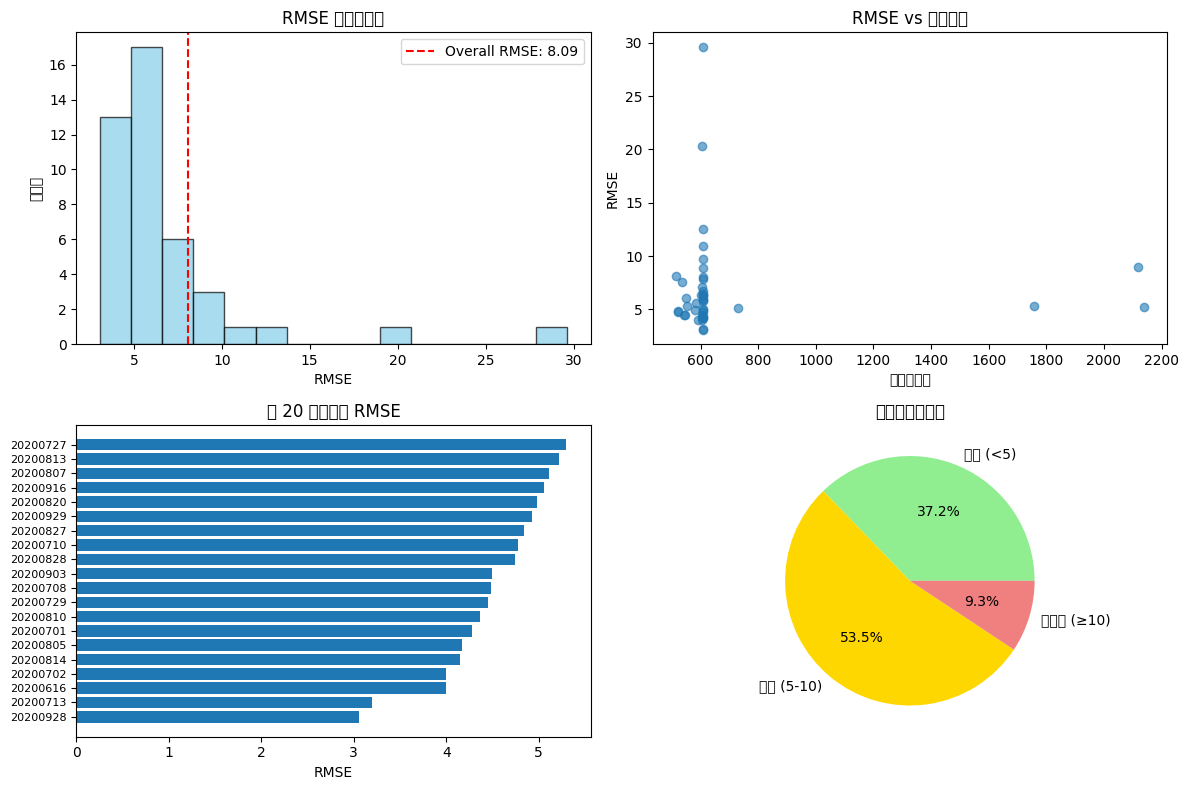


=== 💡 改進建議 ===
🔧 可嘗試改進：
   • 調整超參數
   • 添加時間序列特徵
   • 針對表現差的檔案單獨建模

=== 📈 基準比較 ===
目前 RMSE: 8.089
簡單基準 (均值預測): 16.255
改進幅度: 50.2%


In [16]:
# === 📊 模型準確度綜合評估 ===
import matplotlib.pyplot as plt
import seaborn as sns

print("=== 📊 ElasticNet 模型準確度評估 ===")
print(f"整體 RMSE: {elastic_overall_rmse:.3f}")
print(f"整體 MAE:  {elastic_overall_mae:.3f}")

# 1. 目標變數尺度分析
print("\n=== 🎯 目標變數統計 ===")
target_stats = train_df[TARGETS].describe()
print(target_stats)

# 2. 相對誤差分析 (RMSE / 目標變數標準差)
disp_x_std = train_df["Disp. X"].std()
disp_z_std = train_df["Disp. Z"].std()
relative_rmse_x = elastic_overall_rmse / disp_x_std
relative_rmse_z = elastic_overall_rmse / disp_z_std

print(f"\n=== 📏 相對誤差評估 ===")
print(f"Disp. X 標準差: {disp_x_std:.3f}")
print(f"Disp. Z 標準差: {disp_z_std:.3f}")
print(f"相對 RMSE (X): {relative_rmse_x:.1%}")
print(f"相對 RMSE (Z): {relative_rmse_z:.1%}")

# 3. 準確度分級
def accuracy_grade(rmse_val):
    if rmse_val < 5:
        return "🟢 優秀 (< 5)"
    elif rmse_val < 10:
        return "🟡 良好 (5-10)"
    elif rmse_val < 15:
        return "🟠 一般 (10-15)"
    else:
        return "🔴 需改進 (> 15)"

print(f"\n=== 🏆 準確度評級 ===")
print(f"整體評級: {accuracy_grade(elastic_overall_rmse)}")

# 4. 檔案級別準確度分析
good_files = elastic_detail[elastic_detail['rmse_101p'] < 5]
medium_files = elastic_detail[(elastic_detail['rmse_101p'] >= 5) & (elastic_detail['rmse_101p'] < 10)]
poor_files = elastic_detail[elastic_detail['rmse_101p'] >= 10]

print(f"\n=== 📁 檔案準確度分布 ===")
print(f"🟢 優秀檔案 (RMSE < 5):  {len(good_files)}/{len(elastic_detail)} ({len(good_files)/len(elastic_detail)*100:.1f}%)")
print(f"🟡 良好檔案 (RMSE 5-10): {len(medium_files)}/{len(elastic_detail)} ({len(medium_files)/len(elastic_detail)*100:.1f}%)")
print(f"🔴 待改進檔案 (RMSE ≥ 10): {len(poor_files)}/{len(elastic_detail)} ({len(poor_files)/len(elastic_detail)*100:.1f}%)")

# 5. 最需要改進的檔案
print(f"\n=== ⚠️  最需要改進的 5 個檔案 ===")
worst_files = elastic_detail.tail(5)[['file', 'rmse_101p', 'rows_total']]
display(worst_files)

# 6. 視覺化 RMSE 分布
plt.figure(figsize=(12, 8))

# 子圖 1: RMSE 分布直方圖
plt.subplot(2, 2, 1)
plt.hist(elastic_detail['rmse_101p'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(elastic_overall_rmse, color='red', linestyle='--', label=f'Overall RMSE: {elastic_overall_rmse:.2f}')
plt.xlabel('RMSE')
plt.ylabel('檔案數')
plt.title('RMSE 分布直方圖')
plt.legend()

# 子圖 2: RMSE vs 檔案大小
plt.subplot(2, 2, 2)
plt.scatter(elastic_detail['rows_total'], elastic_detail['rmse_101p'], alpha=0.6)
plt.xlabel('檔案總行數')
plt.ylabel('RMSE')
plt.title('RMSE vs 檔案大小')

# 子圖 3: 前 20 檔案 RMSE
plt.subplot(2, 2, 3)
top20 = elastic_detail.head(20)
plt.barh(range(len(top20)), top20['rmse_101p'])
plt.yticks(range(len(top20)), [f.split('_')[1][:8] for f in top20['file']], fontsize=8)
plt.xlabel('RMSE')
plt.title('前 20 最佳檔案 RMSE')

# 子圖 4: 準確度分級圓餅圖
plt.subplot(2, 2, 4)
accuracy_counts = [len(good_files), len(medium_files), len(poor_files)]
labels = ['優秀 (<5)', '良好 (5-10)', '待改進 (≥10)']
colors = ['lightgreen', 'gold', 'lightcoral']
plt.pie(accuracy_counts, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('檔案準確度分布')

plt.tight_layout()
plt.show()

# 7. 改進建議
print(f"\n=== 💡 改進建議 ===")
if elastic_overall_rmse > 10:
    print("🔧 建議優先改進：")
    print("   • 增加特徵工程 (移動平均、差分)")
    print("   • 嘗試非線性模型 (XGBoost, Random Forest)")
    print("   • 檢查異常值和缺失值處理")
elif elastic_overall_rmse > 5:
    print("🔧 可嘗試改進：")
    print("   • 調整超參數")
    print("   • 添加時間序列特徵")
    print("   • 針對表現差的檔案單獨建模")
else:
    print("✅ 模型表現良好！可考慮：")
    print("   • 模型融合 (Ensemble)")
    print("   • 微調超參數以進一步提升")

print(f"\n=== 📈 基準比較 ===")
print(f"目前 RMSE: {elastic_overall_rmse:.3f}")
print(f"簡單基準 (均值預測): {train_df[TARGETS].std().mean():.3f}")
print(f"改進幅度: {(train_df[TARGETS].std().mean() - elastic_overall_rmse) / train_df[TARGETS].std().mean() * 100:.1f}%")

In [15]:
# === 📂 檢查兩個演算法的預測輸出品質 ===
print("=== 📂 預測輸出檢查 ===")

# 1. 確認路徑設定
print(f"訓練資料路徑 (TRAIN_DIR): {TRAIN_DIR}")
print(f"🔵 ElasticNet 輸出路徑: {OUT_DIR_ELASTIC}")
try:
    print(f"🟣 BayesianRidge 輸出路徑: {OUT_DIR_BAYES}")
    has_bayes = True
except NameError:
    print("🟣 BayesianRidge 輸出路徑: 未定義 (需先執行 BayesianRidge 訓練)")
    has_bayes = False

# 2. 檢查預測檔案
elastic_files = sorted(Path(OUT_DIR_ELASTIC).glob('*.csv'))
print(f"\n📄 ElasticNet 預測檔案數: {len(elastic_files)}")

if has_bayes:
    bayes_files = sorted(Path(OUT_DIR_BAYES).glob('*.csv'))
    print(f"📄 BayesianRidge 預測檔案數: {len(bayes_files)}")

def check_prediction_quality(pred_files, algorithm_name, color_emoji):
    if len(pred_files) > 0:
        # 3. 隨機檢查一個預測檔案
        sample_pred_file = pred_files[0]
        print(f"\n{color_emoji} === {algorithm_name} 預測品質檢查 ===")
        print(f"📋 檢查檔案: {sample_pred_file.name}")
        
        pred_df = pd.read_csv(sample_pred_file)
        print(f"檔案大小: {pred_df.shape}")
        
        # 檢查前 100 行與後面的差異
        if len(pred_df) > 100:
            print(f"\n🔍 前後資料比較:")
            print(f"前 5 行 Disp.X 範圍: {pred_df['Disp. X'].iloc[:5].min():.3f} ~ {pred_df['Disp. X'].iloc[:5].max():.3f}")
            print(f"101+ 行 Disp.X 範圍: {pred_df['Disp. X'].iloc[100:].min():.3f} ~ {pred_df['Disp. X'].iloc[100:].max():.3f}")
            print(f"前 5 行 Disp.Z 範圍: {pred_df['Disp. Z'].iloc[:5].min():.3f} ~ {pred_df['Disp. Z'].iloc[:5].max():.3f}")
            print(f"101+ 行 Disp.Z 範圍: {pred_df['Disp. Z'].iloc[100:].min():.3f} ~ {pred_df['Disp. Z'].iloc[100:].max():.3f}")
            
            # 檢查預測值是否合理
            pred_x_std = pred_df['Disp. X'].iloc[100:].std()
            pred_z_std = pred_df['Disp. Z'].iloc[100:].std()
            
            print(f"\n📊 預測值統計:")
            print(f"預測 Disp.X 標準差: {pred_x_std:.3f}")
            print(f"預測 Disp.Z 標準差: {pred_z_std:.3f}")
            
            # 檢查是否有異常值
            x_outliers = ((pred_df['Disp. X'].iloc[100:].abs() > 100).sum())
            z_outliers = ((pred_df['Disp. Z'].iloc[100:].abs() > 100).sum())
            
            print(f"\n⚠️  異常值檢查 (絕對值 > 100):")
            print(f"Disp.X 異常值: {x_outliers} 個")
            print(f"Disp.Z 異常值: {z_outliers} 個")
            
            if x_outliers == 0 and z_outliers == 0:
                print("✅ 預測值看起來正常！")
            else:
                print("🔴 發現異常預測值，可能需要檢查模型")
                
        # 4. 顯示預測檔案樣本
        print(f"\n📝 預測檔案內容 (前 3 行 + 101-103 行):")
        display(pd.concat([pred_df.head(3), pred_df.iloc[100:103]]))
        
    else:
        print(f"\n{color_emoji} ❌ 找不到 {algorithm_name} 預測檔案")

# 檢查 ElasticNet 預測品質
check_prediction_quality(elastic_files, "ElasticNet", "🔵")

# 檢查 BayesianRidge 預測品質 (如果存在)
if has_bayes:
    check_prediction_quality(bayes_files, "BayesianRidge", "🟣")

# 5. 路徑澄清說明  
print(f"\n📍 路徑說明:")
print(f"🔵 TRAIN_DIR: 原始訓練資料 (用於訓練模型)")
print(f"🟢 OUT_DIR_ELASTIC: ElasticNet 預測結果輸出")
if has_bayes:
    print(f"🟣 OUT_DIR_BAYES: BayesianRidge 預測結果輸出")
print(f"🟡 RMSE 評估: 使用 TRAIN_DIR 資料的 101+ 行")
print(f"🟠 預測品質: 檢查各演算法輸出目錄內的預測結果合理性")

# 6. 比較兩個演算法的預測差異 (如果都存在)
if has_bayes and len(elastic_files) > 0 and len(bayes_files) > 0:
    print(f"\n🔄 === 預測結果差異比較 ===")
    
    # 選擇同一個檔案比較
    common_files = set([f.name for f in elastic_files]) & set([f.name for f in bayes_files])
    if common_files:
        sample_file = list(common_files)[0]
        elastic_pred = pd.read_csv(OUT_DIR_ELASTIC + "/" + sample_file)
        bayes_pred = pd.read_csv(OUT_DIR_BAYES + "/" + sample_file)
        
        if len(elastic_pred) > 100 and len(bayes_pred) > 100:
            # 計算 101+ 行的預測差異
            elastic_x = elastic_pred['Disp. X'].iloc[100:].values
            elastic_z = elastic_pred['Disp. Z'].iloc[100:].values
            bayes_x = bayes_pred['Disp. X'].iloc[100:].values
            bayes_z = bayes_pred['Disp. Z'].iloc[100:].values
            
            diff_x = np.abs(elastic_x - bayes_x)
            diff_z = np.abs(elastic_z - bayes_z)
            
            print(f"📊 檔案 {sample_file} 預測差異:")
            print(f"Disp.X 平均絕對差異: {diff_x.mean():.4f}")
            print(f"Disp.Z 平均絕對差異: {diff_z.mean():.4f}")
            print(f"Disp.X 最大絕對差異: {diff_x.max():.4f}")
            print(f"Disp.Z 最大絕對差異: {diff_z.max():.4f}")
            
            if diff_x.mean() < 1.0 and diff_z.mean() < 1.0:
                print("✅ 兩個演算法預測結果相近")
            else:
                print("🔍 兩個演算法預測結果差異較大，可進一步分析")

=== 📂 預測輸出檢查 ===
訓練資料路徑 (TRAIN_DIR): /Users/benjamin/1132/11325/AI_Race/2025_dataset_0806 3/train
🔵 ElasticNet 輸出路徑: /Users/benjamin/1132/11325/AI_Race/preds_out_elasticnet
🟣 BayesianRidge 輸出路徑: /Users/benjamin/1132/11325/AI_Race/preds_out_bayesian

📄 ElasticNet 預測檔案數: 43
📄 BayesianRidge 預測檔案數: 43

🔵 === ElasticNet 預測品質檢查 ===
📋 檢查檔案: _20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-from0-25C).csv
檔案大小: (515, 27)

🔍 前後資料比較:
前 5 行 Disp.X 範圍: -2.178 ~ 0.000
101+ 行 Disp.X 範圍: -25.978 ~ 31.212
前 5 行 Disp.Z 範圍: 0.000 ~ 0.172
101+ 行 Disp.Z 範圍: -39.963 ~ -15.712

📊 預測值統計:
預測 Disp.X 標準差: 17.050
預測 Disp.Z 標準差: 5.297

⚠️  異常值檢查 (絕對值 > 100):
Disp.X 異常值: 0 個
Disp.Z 異常值: 0 個
✅ 預測值看起來正常！

📝 預測檔案內容 (前 3 行 + 101-103 行):


,Time,PT01,PT02,PT03,PT04,PT05,PT06,PT07,PT08,PT09,...,TC04,TC05,TC06,TC07,TC08,Spindle Motor,X Motor,Z Motor,Disp. X,Disp. Z
0,1.017,21.5,21.7,21.8,21.1,21.2,20.9,20.9,21.6,21.1,...,19.1,19.4,19.6,21.6,22.3,19.0,19.0,20.0,0.000000,0.000000
1,1.185,21.5,21.8,21.8,21.1,21.2,20.9,20.9,21.6,21.2,...,19.4,19.5,19.7,21.7,22.4,19.0,19.0,20.0,0.000000,0.086104
2,1.354,21.5,21.8,21.8,21.1,21.2,20.9,20.9,21.6,21.2,...,19.2,19.5,19.8,21.7,22.4,19.0,20.0,20.0,-1.188165,0.086104
100,20.418,22.2,23.3,23.3,21.4,22.4,24.1,21.5,24.6,25.1,...,20.2,21.0,20.7,23.6,22.9,23.0,21.0,21.0,-16.043263,-16.470672
101,21.093,22.3,23.4,23.3,21.5,22.5,24.2,21.5,24.7,25.1,...,20.2,21.0,20.6,23.7,23.0,23.0,21.0,21.0,-13.709698,-15.711761
102,21.766,22.3,23.4,23.4,21.5,22.5,24.2,21.5,24.8,25.2,...,20.3,21.0,20.7,23.9,23.1,23.0,21.0,21.0,-13.056274,-15.918874



🟣 === BayesianRidge 預測品質檢查 ===
📋 檢查檔案: _20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-from0-25C).csv
檔案大小: (515, 27)

🔍 前後資料比較:
前 5 行 Disp.X 範圍: -2.178 ~ 0.000
101+ 行 Disp.X 範圍: -26.004 ~ 31.506
前 5 行 Disp.Z 範圍: 0.000 ~ 0.172
101+ 行 Disp.Z 範圍: -41.344 ~ -16.672

📊 預測值統計:
預測 Disp.X 標準差: 16.853
預測 Disp.Z 標準差: 5.448

⚠️  異常值檢查 (絕對值 > 100):
Disp.X 異常值: 0 個
Disp.Z 異常值: 0 個
✅ 預測值看起來正常！

📝 預測檔案內容 (前 3 行 + 101-103 行):


,Time,PT01,PT02,PT03,PT04,PT05,PT06,PT07,PT08,PT09,...,TC04,TC05,TC06,TC07,TC08,Spindle Motor,X Motor,Z Motor,Disp. X,Disp. Z
0,1.017,21.5,21.7,21.8,21.1,21.2,20.9,20.9,21.6,21.1,...,19.1,19.4,19.6,21.6,22.3,19.0,19.0,20.0,0.000000,0.000000
1,1.185,21.5,21.8,21.8,21.1,21.2,20.9,20.9,21.6,21.2,...,19.4,19.5,19.7,21.7,22.4,19.0,19.0,20.0,0.000000,0.086104
2,1.354,21.5,21.8,21.8,21.1,21.2,20.9,20.9,21.6,21.2,...,19.2,19.5,19.8,21.7,22.4,19.0,20.0,20.0,-1.188165,0.086104
100,20.418,22.2,23.3,23.3,21.4,22.4,24.1,21.5,24.6,25.1,...,20.2,21.0,20.7,23.6,22.9,23.0,21.0,21.0,-16.217832,-17.250831
101,21.093,22.3,23.4,23.3,21.5,22.5,24.2,21.5,24.7,25.1,...,20.2,21.0,20.6,23.7,23.0,23.0,21.0,21.0,-14.738924,-17.040140
102,21.766,22.3,23.4,23.4,21.5,22.5,24.2,21.5,24.8,25.2,...,20.3,21.0,20.7,23.9,23.1,23.0,21.0,21.0,-13.808962,-16.671998



📍 路徑說明:
🔵 TRAIN_DIR: 原始訓練資料 (用於訓練模型)
🟢 OUT_DIR_ELASTIC: ElasticNet 預測結果輸出
🟣 OUT_DIR_BAYES: BayesianRidge 預測結果輸出
🟡 RMSE 評估: 使用 TRAIN_DIR 資料的 101+ 行
🟠 預測品質: 檢查各演算法輸出目錄內的預測結果合理性

🔄 === 預測結果差異比較 ===
📊 檔案 _20200709_GV1-1203_1000rpm_XZ-5m-min_6H(wAC-from0-20Cto25C).csv 預測差異:
Disp.X 平均絕對差異: 0.4811
Disp.Z 平均絕對差異: 0.4775
Disp.X 最大絕對差異: 1.6193
Disp.Z 最大絕對差異: 1.7465
✅ 兩個演算法預測結果相近
